In [1]:
from adversarial_lab.core import ALModel
from adversarial_lab.core.noise_generators import AdditiveNoiseGenerator
from adversarial_lab.attacker.blackbox import BlackBoxMisclassificationAttack
from adversarial_lab.core.gradient_estimator import FiniteDifferenceGE
from adversarial_lab.core.preprocessing import PreprocessingFromFunction
from adversarial_lab.utils import Plotting
from adversarial_lab.core.constraints import POClip, PONoisedSampleBounding

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions


In [2]:
model = MobileNetV2(input_shape=(96, 96, 3), include_top=True, weights='imagenet')

def preprocess(samples, *args, **kwargs):
    processed = []
    for sample in samples:
        input = tf.cast(sample, dtype=tf.float32)
        if len(input.shape) == 2:
            input = tf.expand_dims(input, axis=-1)
            input = tf.image.grayscale_to_rgb(input)
        elif len(input.shape) == 3 and input.shape[-1] == 1:
            input = tf.image.grayscale_to_rgb(input)

        resized_image = tf.image.resize(input, (96, 96))
        processed.append(resized_image)

    batch = tf.stack(processed)
    return preprocess_input(batch)

# Prediction function
def pred(samples):
    samples_for_pred = preprocess(samples)
    preds = model.predict(samples_for_pred, verbose=0)
    return [p for p in preds]

In [3]:
image = Image.open('data/panda.jpg')
image_array = np.array(image)
image_array = np.resize(image_array, (64, 64, 3))

np.argmax(pred([image_array]))

858

In [4]:
from adversarial_lab.core.losses import CategoricalCrossEntropy
from adversarial_lab.core.penalties import LpNorm
from adversarial_lab.core.optimizers import PGD

optim = PGD(learning_rate=1.0)
grad_estimator = FiniteDifferenceGE(epsilon=1, batch_size=32, block_size=32)
loss = CategoricalCrossEntropy()

In [5]:
con1 = POClip(min=-2, max=2)
con2 = PONoisedSampleBounding(min=0, max=255)

In [6]:
ng = AdditiveNoiseGenerator(scale=[0, 255], dist="zeros")

In [7]:
attacker = BlackBoxMisclassificationAttack(
    pred, optim, loss, noise_generator=ng, gradient_estimator=grad_estimator, constraints=[con1, con2], verbose=3)

In [8]:
noise = attacker.attack(image_array, target_class=924,
                        epochs=20, strategy="random")

Attacking:   0%|          | 0/20 [00:00<?, ?it/s]

Attacking: 100%|██████████| 20/20 [22:22<00:00, 70.53s/it, Loss=6.42, Prediction (score)=858(0.067), Original Class (score)=858(0.067), Target Class (score)=924(0.002)]

In [9]:
print(np.min(image_array+noise[0]), np.max(image_array+noise[0]))
print(np.min(noise[0]), np.max(noise[0]))

0.0 234.0
-2.0 2.0


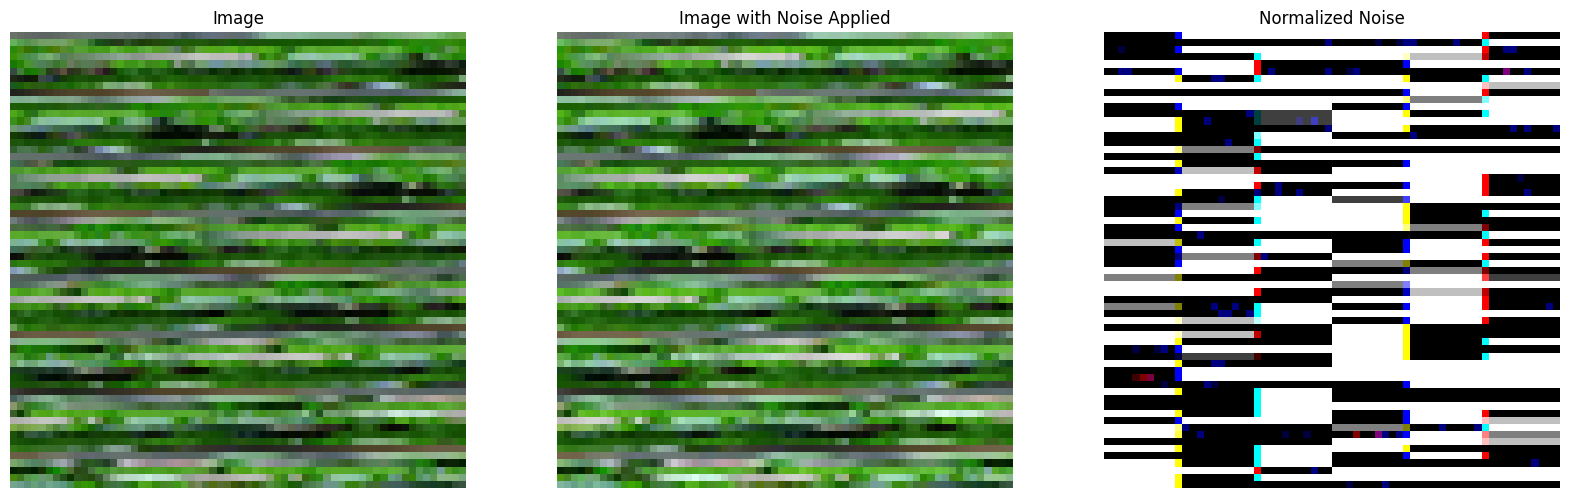

In [10]:
Plotting.plot_images_and_noise(image_array, noise[0])